In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd # For maps
import random
from copy import deepcopy

# Data Filtering / Preprocessing and Visualization

In [ ]:
file_path = 'clustering_data.csv'
clustering_data = pd.read_csv(file_path, low_memory = False)
# Filtering to keep only the Kerala states
state_name = 'Kerala'
clustering_data = clustering_data[clustering_data['StateName'] == state_name.upper()]
print(clustering_data.head())
print(clustering_data.columns)

          CircleName      RegionName        DivisionName  \
13386  Kerala Circle    Kochi Region    Trichur Division   
13558  Kerala Circle  Calicut Region  Cannanore Division   
14010  Kerala Circle    Kochi Region  Ernakulam Division   
19764  Kerala Circle    Kochi Region  Ernakulam Division   
19765  Kerala Circle    Kochi Region  Ernakulam Division   

                            OfficeName  Pincode OfficeType  Delivery  \
13386  NODAL DELIVERY CENTER, THRISSUR   680001         PO  Delivery   
13558                    Madakkara B.O   670301         BO  Delivery   
14010                     Kakkanad NDC   682052         PO  Delivery   
19764  Kalamassery Development Plot BO   683104         BO  Delivery   
19765                      Rajagiri BO   683104         BO  Delivery   

        District StateName     Latitude    Longitude  
13386   THRISSUR    KERALA  10.30439668  76.12562572  
13558     KANNUR    KERALA   11.9610706   75.2976672  
14010  ERNAKULAM    KERALA      10.0212  

In [ ]:
# Checking for missing values
missing_values = clustering_data.isnull().sum()
print("Missing values in each column is\n", missing_values)
missing_data = clustering_data[clustering_data.isnull().any(axis=1)]
print("\nRows with missing values:")
print(missing_data)

Missing values in each column is
 CircleName      0
RegionName      0
DivisionName    0
OfficeName      0
Pincode         0
OfficeType      0
Delivery        0
District        0
StateName       0
Latitude        1
Longitude       1
dtype: int64

Rows with missing values:
          CircleName      RegionName         DivisionName  OfficeName  \
63923  Kerala Circle  Calicut Region  Thalassery Division  Kayani B.O   

       Pincode OfficeType  Delivery District StateName Latitude Longitude  
63923   670702         BO  Delivery   KANNUR    KERALA      NaN       NaN  


Since there's only one missing latitutde + longitude for Kerala, we're just dropping it. Alternative is to set it as some statistic measure or via interpolation.

In [ ]:
# Dropping the missing data row
clustering_data = clustering_data.dropna()

In [ ]:
# To get a feeler for what the data looks like
print(clustering_data.info())
print()
print(clustering_data.describe())
print()

<class 'pandas.core.frame.DataFrame'>
Index: 5061 entries, 13386 to 157125
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CircleName    5061 non-null   object
 1   RegionName    5061 non-null   object
 2   DivisionName  5061 non-null   object
 3   OfficeName    5061 non-null   object
 4   Pincode       5061 non-null   int64 
 5   OfficeType    5061 non-null   object
 6   Delivery      5061 non-null   object
 7   District      5061 non-null   object
 8   StateName     5061 non-null   object
 9   Latitude      5061 non-null   object
 10  Longitude     5061 non-null   object
dtypes: int64(1), object(10)
memory usage: 474.5+ KB
None

             Pincode
count    5061.000000
mean   682180.449318
std      7635.875584
min    670001.000000
25%    676102.000000
50%    680721.000000
75%    688562.000000
max    695615.000000



In [ ]:
# Same as above
print(clustering_data.columns)
print()
print(clustering_data.value_counts())
print()

Index(['CircleName', 'RegionName', 'DivisionName', 'OfficeName', 'Pincode',
       'OfficeType', 'Delivery', 'District', 'StateName', 'Latitude',
       'Longitude'],
      dtype='object')

CircleName     RegionName      DivisionName         OfficeName            Pincode  OfficeType  Delivery      District    StateName  Latitude    Longitude 
Kerala Circle  Calicut Region  Calicut Division     Achooranam BO         673575   BO          Delivery      WAYANAD     KERALA     11.6        76            1
               Kochi Region    Alwaye Division      Chully BO             683581   BO          Delivery      ERNAKULAM   KERALA     12.3928625  75.3185748    1
                                                    Elanthikara BO        683594   BO          Delivery      ERNAKULAM   KERALA     10.1745149  76.2665658    1
                                                    Elanji SO             686665   PO          Delivery      ERNAKULAM   KERALA     9.47        76.95         1
               

In [ ]:
# NOTE: This throws an ERROR!
# An attempt to convert lat + longitude to numeric but it fails.
clustering_data['Latitude'] = pd.to_numeric(clustering_data['Latitude'])

ValueError: Unable to parse string "8.3256740-" at position 3466

### Continue running from here

In [ ]:
# Identifying the annoying rows which are causing the dtpye to be object
non_numeric_lat = clustering_data[~clustering_data['Latitude'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
non_numeric_lon = clustering_data[~clustering_data['Longitude'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

# Display rows with non-numeric latitude and longitude values
print("\nRows with non-numeric Latitude values:")
print(non_numeric_lat[['Latitude', 'Longitude']])

print("\nRows with non-numeric Longitude values:")
print(non_numeric_lon[['Latitude', 'Longitude']])


Rows with non-numeric Latitude values:
         Latitude  Longitude
81377  8.3256740-  157.26989

Rows with non-numeric Longitude values:
          Latitude     Longitude
61694    32.838379   97.1031050-
64505    40.741211   73.9832160-
70460   44.0667072  103.2008900-
150319   11.245304   73.9695210-


In [ ]:
# Removing the hyphen and then converting the dtypes of both of them to float
clustering_data['Latitude'] = clustering_data['Latitude'].str.replace('-', '')
clustering_data['Longitude'] = clustering_data['Longitude'].str.replace('-', '')

# An alternative option for the above, would be to use regular expressions to only select the float part of the string

clustering_data['Latitude'] = pd.to_numeric(clustering_data['Latitude'])
clustering_data['Longitude'] = pd.to_numeric(clustering_data['Longitude'])
print(clustering_data.dtypes)

CircleName       object
RegionName       object
DivisionName     object
OfficeName       object
Pincode           int64
OfficeType       object
Delivery         object
District         object
StateName        object
Latitude        float64
Longitude       float64
dtype: object


In [ ]:
# Checking for duplicates
duplicates = clustering_data.duplicated()
print(duplicates.value_counts())

# No duplicates, so not a worry.

False    5061
Name: count, dtype: int64


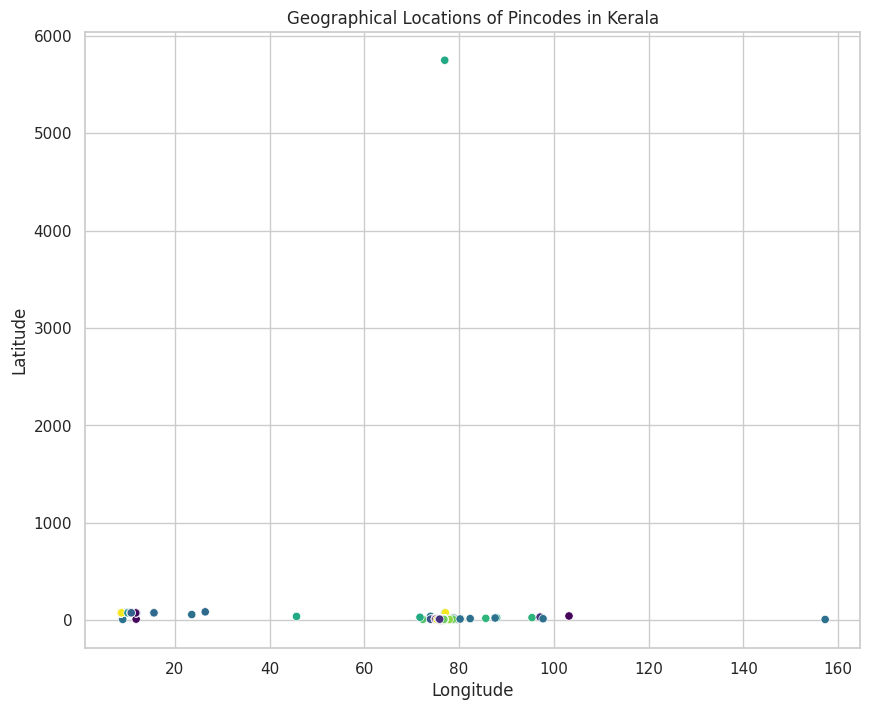

In [ ]:
# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Create scatter plot
sns.scatterplot(data=clustering_data, x='Longitude', y='Latitude', hue='Pincode', palette='viridis', legend=False)

# Customize plot
state_name = "Kerala"
plt.title(f'Geographical Locations of Pincodes in {state_name.capitalize()}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()

Notice the issue? The points are all over the place. We'll use this library called geopandas to keep it within the boundary of Kerala itself.

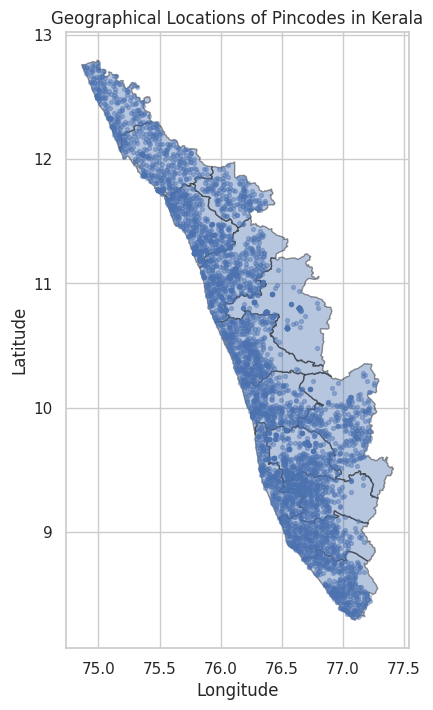

In [ ]:
kerala_boundary_file = 'district.geojson'
kerala_boundary = gpd.read_file(kerala_boundary_file)

# This basically converts the original data into a copy but in a geodataframe format
data_within_kerala = gpd.GeoDataFrame(clustering_data, geometry=gpd.points_from_xy(clustering_data['Longitude'], clustering_data['Latitude']))

# There's a warning regarding CRS (Corrdinate Reference System) if both kerala_boundary and data_within_kerala don't have the same CRS.
# The CRS of data_within_kerala is None, so we'll change that to be EPSG:4326 to match that of kerala_boundary (not sure 100% what change this exactly does)

if data_within_kerala.crs is None:
    data_within_kerala.crs = 'EPSG:4326'

# Now we filter based on the boundary
data_within_kerala = gpd.sjoin(data_within_kerala, kerala_boundary, predicate='within')

# Now let's start plotting!
# First some basic settings
plt.figure(figsize=(10, 8))

# Then the Kerala boundary. This is done with a built-in function of the GeoDataFrame, which uses matplotlib under the hood.
kerala_boundary.plot(ax=plt.gca(), alpha=0.4, edgecolor='black')

# Then the pincode locations using seaborn
plt.scatter(x=data_within_kerala['Longitude'], y=data_within_kerala['Latitude'], s=8, alpha = 0.4)

# Customize plot
plt.title(f'Geographical Locations of Pincodes in {state_name.capitalize()}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()


In [ ]:
# Converting for geodataframe to regular data frame with the old columns only
data_within_kerala_df = pd.DataFrame(data_within_kerala, copy = True)[['CircleName', 'RegionName', 'DivisionName', 'OfficeName', 'Pincode', 'OfficeType', 'Delivery', 'District', 'StateName', 'Latitude', 'Longitude']]
print(data_within_kerala_df.head())
print(data_within_kerala_df.columns)
print(data_within_kerala_df.dtypes)

# Taking the latitude and longitude and joining them and storing them as a simple numpy array
latlong_points = data_within_kerala_df[['Longitude', 'Latitude']].to_numpy()

          CircleName          RegionName        DivisionName  \
13386  Kerala Circle        Kochi Region    Trichur Division   
31111  Kerala Circle        Kochi Region     Idukki Division   
50118  Kerala Circle        Kochi Region     Idukki Division   
52404  Kerala Circle  DivReportingCircle  Tiruvalla Division   
60158  Kerala Circle      Calicut Region    Manjeri Division   

                            OfficeName  Pincode OfficeType  Delivery  \
13386  NODAL DELIVERY CENTER, THRISSUR   680001         PO  Delivery   
31111                  Vadakkummury BO   685586         BO  Delivery   
50118                   Kailasanadu BO   685553         BO  Delivery   
52404                    Thekkumkal BO   689614         BO  Delivery   
60158                      Meppadam BO   676542         BO  Delivery   

             District StateName   Latitude  Longitude  
13386        THRISSUR    KERALA  10.304397  76.125626  
31111          IDUKKI    KERALA  10.428556  76.117499  
50118         

# K Means Clustering
The idea is to set k random centroids on the map, and have them converge to the point where, the center of the closest neighbors of each centroid, is at the location the centroid itself is. Then, we can label each point based on the closest centroid and we now have a group of clusters. For what results we can infer from this, see the results section below.

In [ ]:
# THE k from the k means clustering
k = 14

def k_means_clustering(data, k):
    def distance(a, b):
        return np.linalg.norm(a - b)

    # Step 1: Place k random centroids

    centroids_x = np.random.choice(latlong_points[:, 0], size=k)
    centroids_y = np.random.choice(latlong_points[:, 1], size=k)
    centroids = np.array(list(zip(centroids_x, centroids_y)))

    # To store the value of centroids when it updates
    centroids_old = np.zeros(centroids.shape)

    # Cluster labels (either 0, 1, 2, ..., k - 1) for the label of each point on the map
    labels = np.zeros(len(latlong_points))

    # Just a useful array to store distances
    distances = np.zeros(k)

    # Initialize error:
    error = np.zeros(k)
    for i in range(k):
        error[i] = distance(centroids[i], centroids_old[i])

    # Repeat Steps 2 and 3 till centroids converge

    while error.all() != 0:
        # Step 2: Assign samples to nearest centroid
        for i in range(len(latlong_points)):
            for j in range(k):
                distances[j] = distance(latlong_points[i], centroids[j])
            cluster = np.argmin(distances) # argmin simply gives the index of the minimum element
            labels[i] = cluster

        # Step 3: Update centroids

        centroids_old = deepcopy(centroids)

        for i in range(k):
            points = [latlong_points[j] for j in range(len(latlong_points)) if labels[j] == i]
            if (len(points) > 0): # So that we're not taking mean of empty cluster arrays
                centroids[i] = np.mean(points, axis=0)
            else: # So that centroids[i] can still keep going
                centroids[i] = latlong_points[random.randint(0, len(latlong_points))]

        # Update error
        for i in range(k):
            error[i] = distance(centroids[i], centroids_old[i])

    return labels, centroids

In [ ]:
def plot_k_means_clusters(data, labels, centroids, border = None):
    k = len(centroids)
    # Using a color paletter for fancy but varying colors
    palette = sns.color_palette("viridis", k)

    plt.figure(figsize=(10, 8))

    # To set a border if provided
    if border is not None:
        border.plot(ax=plt.gca(), alpha=0.4, edgecolor='black')

    # Plot each point a different color based on the label provided
    for i in range(k):
        points = np.array([latlong_points[j] for j in range(len(latlong_points)) if labels[j] == i])
        plt.scatter(points[:, 0], points[:, 1], color=palette[i], alpha=0.1)

    # Plot the centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='s', s=50, color='black', label='Centroids')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('K-Means Clustering of Pincodes in Kerala')
    plt.legend()
    plt.show()

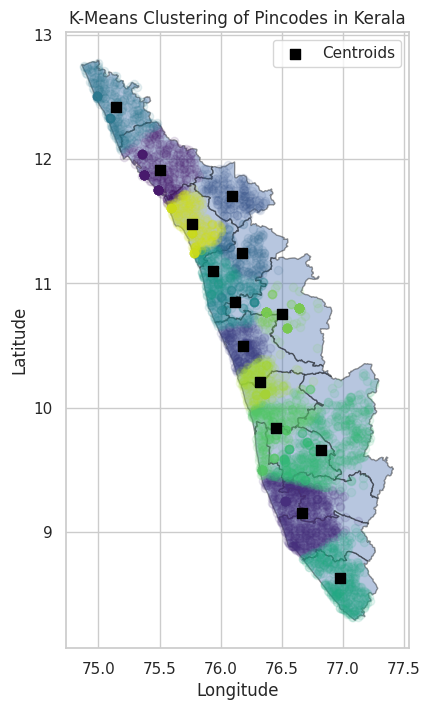

In [ ]:
# Test Run
k = 14 # Cause that's the number of districts in Kerala
labels, centroids = k_means_clustering(latlong_points, k)
plot_k_means_clusters(latlong_points, labels, centroids, kerala_boundary)


It works! Run the code a few times for different values of k. What I noticed was that the output shows up pretty consistently (the centroids in the general same location) for low values of k, as k gets higher, the output also tends to vary a lot more often while running the code again and again.

So. How do we know whether k = 14 is the optimal number, or if it's something else?

# The Elbow Method
This method is a hyperparameter tuning method intended to find the optimal value of k. It finds the within-cluster sum of squares and plots it against k. Where the gain in information starts to decrease more slowly (the elbow point), that's considered the optimal value of k.

### Alternative Methods
There are alternative methods like, the silhouette score (which measures how similar a point is to its own cluster compared to other clusters. It ranges from -1 to 1, where a higher value indicates better-defined clusters.) or the gap statistic (which uses fancy math and I haven't properly understood)

### Reason for chosing the elbow method
This is a well known method used for tuning the value of k, it was a method I felt I could implement myself, so I chose to do it.

In [ ]:
def calculate_wcss(data, max_k):
    wcss = []
    for k in range(1, max_k + 1):
        labels, centroids = k_means_clustering(data, k)
        wcss_k = 0
        for i in range(k):
            points = data[labels == i]
            wcss_k += np.sum((points - centroids[i]) ** 2)
        wcss.append(wcss_k)
    return wcss

def plot_elbow_method(wcss):
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(wcss) + 1), wcss, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal k')
    plt.show()

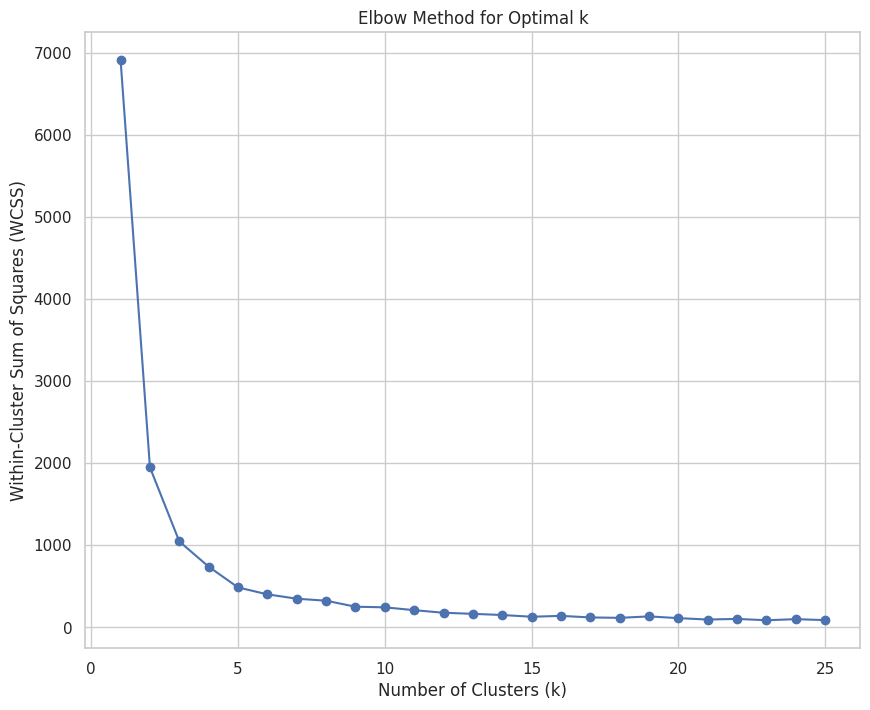

In [ ]:
max_k = 25
wcss = calculate_wcss(latlong_points, max_k)
plot_elbow_method(wcss)

The elbow value looks like it's about 3. Our initial guess was way of the mark!

# Results

How accurate is our result? What do the results show us?

## From the data itself

If we look at the original data provided, for the kerala district, there are 3 unique regions, the Kochi, Calicut and DivReporting regions. This makes it sort of understandable what the k-means clustering algorithm is noticing. 

A conclusion maybe one can make is, which district a pincode is in doesn't tend to have too much of an effect on the density of the population and postal offices itself. The borders of a district don't seem to be a factor on the population density, it seems to be pretty evenly spread. Which could be why the algorithm feels the region to be a more signifcant factor to notice.

## Is that good enough?

But the MAJOR question is, are we capturing the underlying structure of the data. The answer in my opinion is, we can keep checking forever, but there's no definitive answer, it's a subjective question with a subjective answer 🤷, but this is pretty close :D.

## A Comparison

Comparing between the region distribution and the k = 3 case. Pretty similar, just the data is slightly shifted. But it looks a lot more accurate compared to the district comparison.

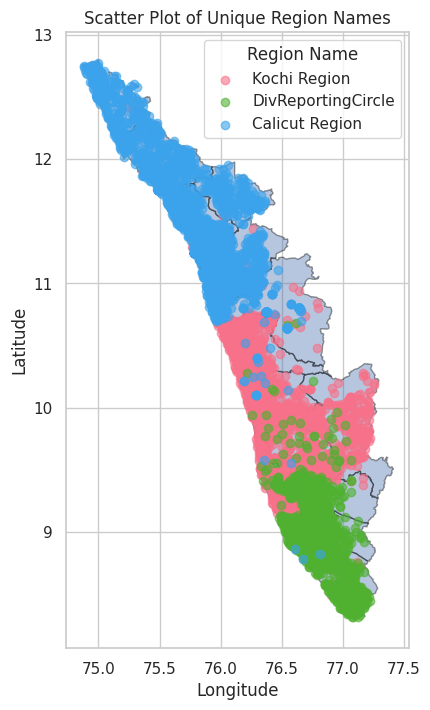

In [ ]:
# Extracting unique region names
unique_region_names = data_within_kerala_df['RegionName'].unique()

# Creating a color palette
palette = sns.color_palette("husl", len(unique_region_names))

# Creating a dictionary to map each region name to a color
color_dict = {region: palette[i] for i, region in enumerate(unique_region_names)}

plt.figure(figsize=(10, 8))
kerala_boundary.plot(ax=plt.gca(), alpha=0.4, edgecolor='black')

# Plotting each region's data points
for region in unique_region_names:
    region_data = data_within_kerala_df[data_within_kerala_df['RegionName'] == region]
    plt.scatter(region_data['Longitude'], region_data['Latitude'],
                color=color_dict[region], label=region, alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Unique Region Names')
plt.legend(title='Region Name')
plt.show()

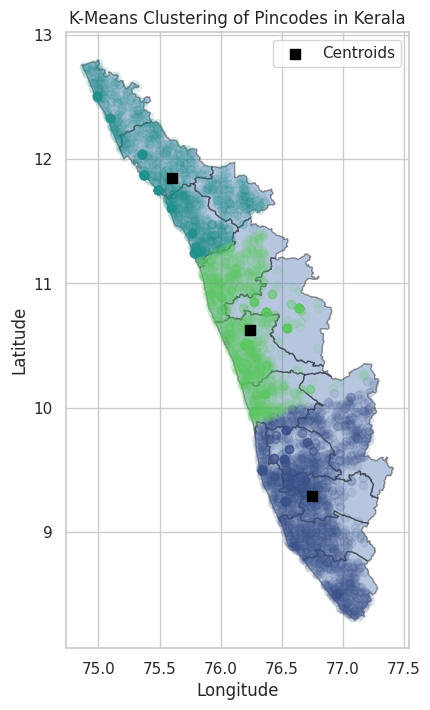

In [ ]:
labels, centroids = k_means_clustering(latlong_points, 3)
plot_k_means_clusters(latlong_points, labels, centroids, kerala_boundary)

# Temp code and stuff below

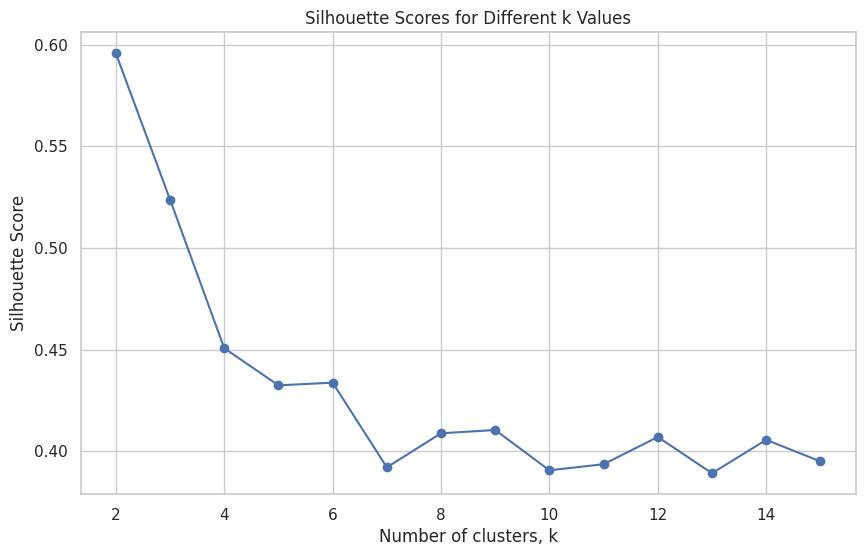

In [ ]:
from sklearn.metrics import silhouette_score

def compute_silhouette_scores(latlong_points, max_k):
    silhouette_scores = []
    K = range(2, max_k + 1)
    for k in K:
        labels, _ = k_means_clustering(latlong_points, k)
        score = silhouette_score(latlong_points, labels)
        silhouette_scores.append(score)
    return K, silhouette_scores

# Compute silhouette scores
K, silhouette_scores = compute_silhouette_scores(latlong_points, 15)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k Values')
plt.show()

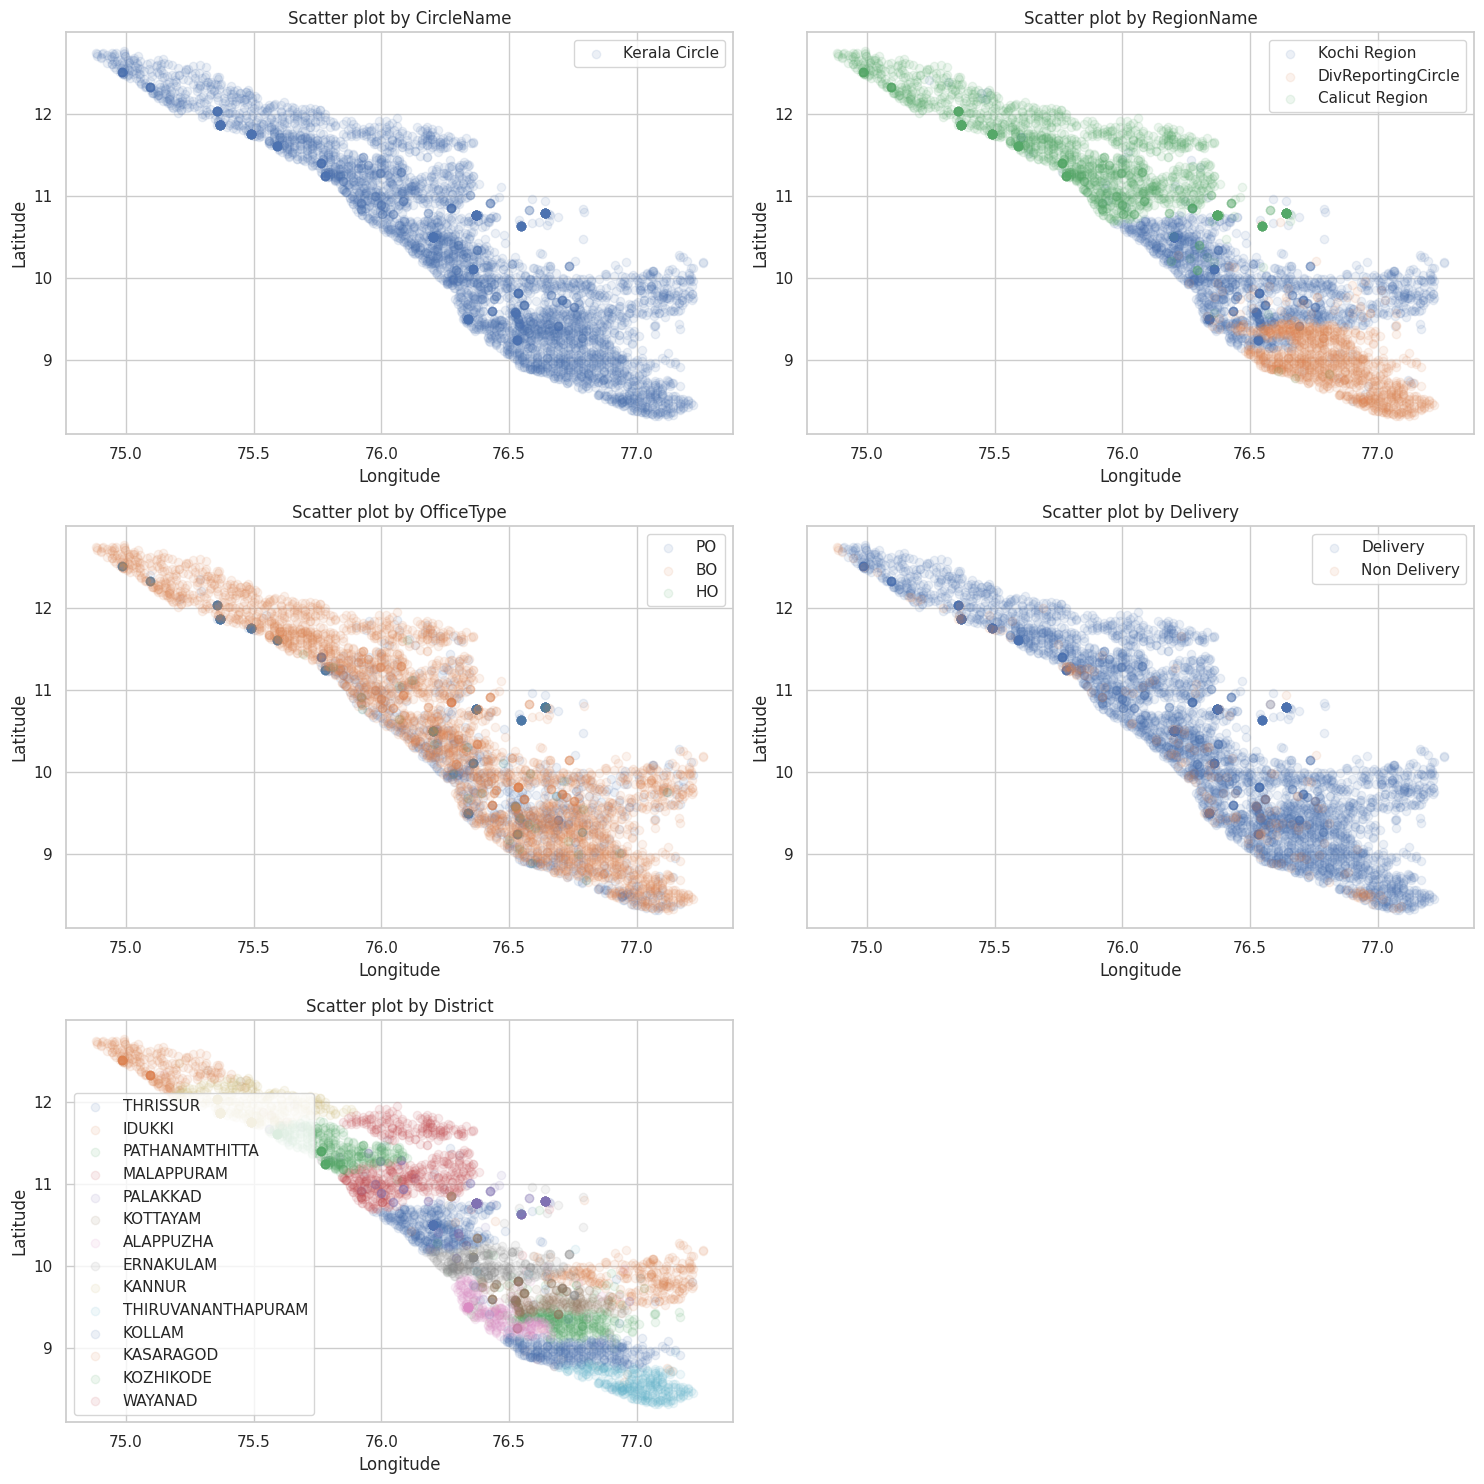

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample dataframe
# data_within_kerala_df = ...

# Columns to create subplots for
columns_to_plot = ['CircleName', 'RegionName', 'OfficeType', 'Delivery', 'District']

# Determine the number of subplots needed
n_plots = len(columns_to_plot)
n_rows = (n_plots + 1) // 2  # Arrange in 2 columns

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 5 * n_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate through each column and create a scatter plot
for idx, column in enumerate(columns_to_plot):
    ax = axes[idx]


    # Group data by the current column
    unique_values = data_within_kerala_df[column].unique()

    # Plot each group with a different color
    for value in unique_values:
        subset = data_within_kerala_df[data_within_kerala_df[column] == value]
        ax.scatter(subset['Longitude'], subset['Latitude'], label=value, alpha=0.1)

    ax.set_title(f'Scatter plot by {column}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend(loc='best')
    ax.grid(True)

# Remove any unused subplots
if n_plots % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


Ideas to look at:
- Post Office Type
- Bordering state data and see how the population density is at the borders.